In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## intial setep

In [13]:
sales=pd.read_csv("daily_sales_french_bakery.csv",parse_dates=["ds"])
sales.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [4]:
sales.shape


(57046, 4)

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57046 entries, 0 to 57045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unique_id   57046 non-null  object 
 1   ds          57046 non-null  object 
 2   y           57046 non-null  float64
 3   unit_price  57046 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.7+ MB


In [6]:
sales.isnull().sum()

unique_id     0
ds            0
y             0
unit_price    0
dtype: int64

In [7]:
sales.duplicated().sum()

np.int64(0)

In [8]:
sales=sales.groupby("unique_id").filter(lambda x: len(x)>=28)
sales=sales.drop(["unit_price"],axis=1)
sales.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


In [10]:
sales['unique_id'].value_counts()

unique_id
BAGUETTE              637
BOULE 400G            637
BANETTE               637
BOULE 200G            637
BANETTINE             637
                     ... 
RELIGIEUSE             71
SABLE F  P             68
DELICETROPICAL         63
VIENNOISE              61
PAIN SUISSE PEPITO     51
Name: count, Length: 121, dtype: int64

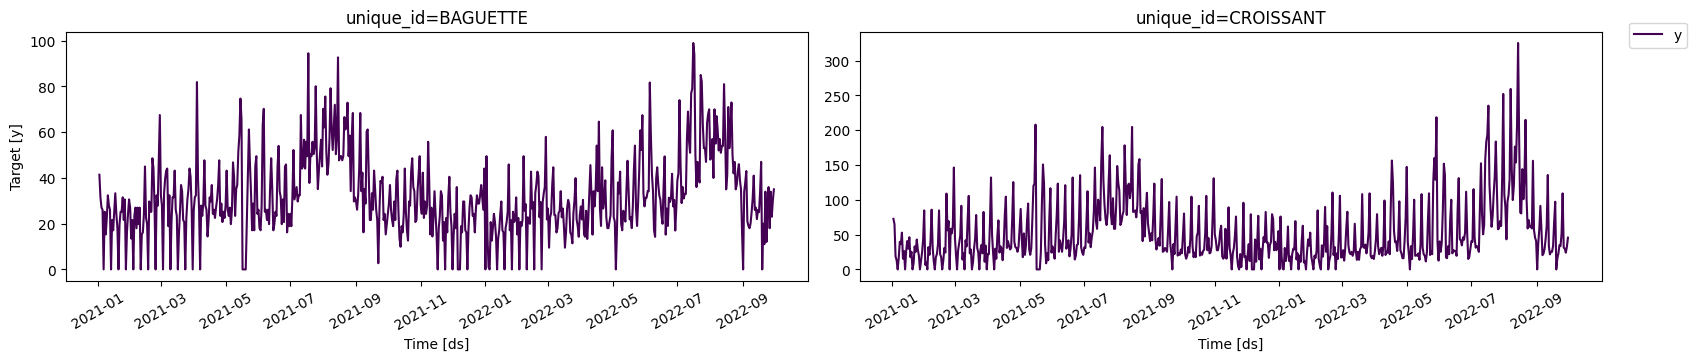

In [14]:
plot_series(df=sales,ids=["BAGUETTE", "CROISSANT"],palette="viridis")


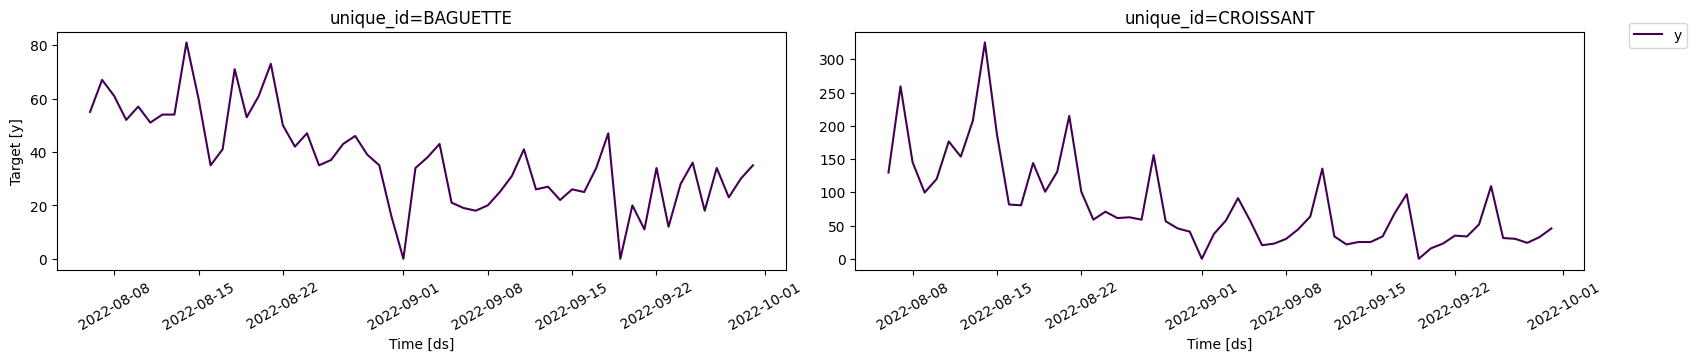

In [15]:
plot_series(df=sales, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

## Baseline Models

In [16]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [25]:
horizon=7
models=[
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=10),
    SeasonalNaive(season_length=7),
]
sf=StatsForecast(
    models=models,
    freq="D",
)
sf.fit(df=sales)
preds = sf.predict(h=horizon)
preds.head()


,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.0,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.0,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.0,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.0,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.0,0.0


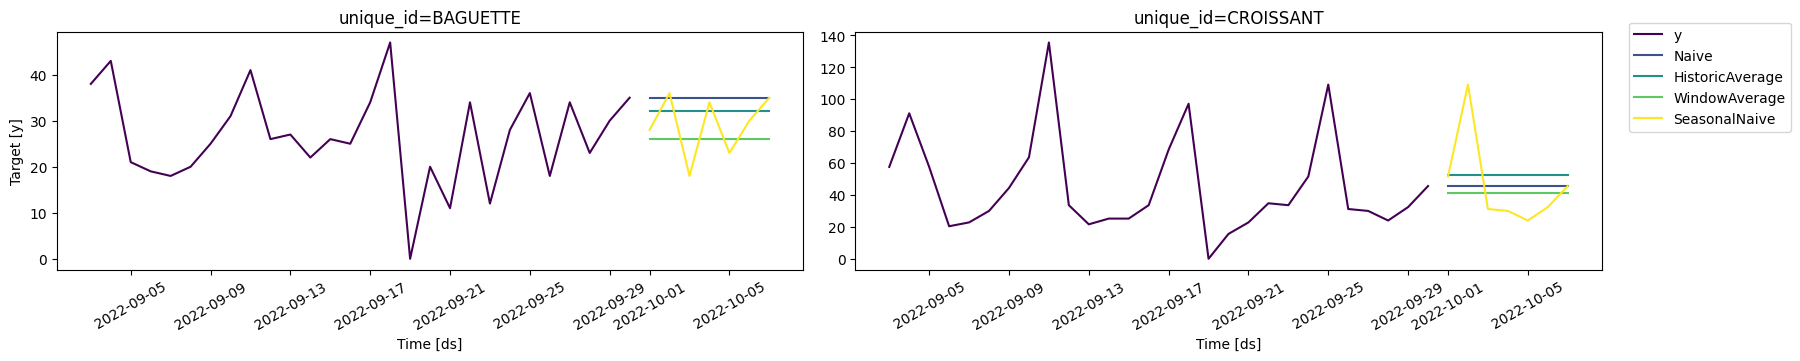

In [26]:
plot_series(
    df=sales, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")